# For testing the program in the following system

## Import all the things we need

In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
from qutip import*
import time
from scipy import *
from scipy import optimize
from scipy.integrate import odeint
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import QCLSolver.data as QCLData
import QCLSolver.solver as QCLS

## Build up the manual version

Build the basic expression

In [2]:
class ProblemSolver:
    'The Problem Solver'
    g=0 #coupling rate
    Delta=np.zeros(2)#[Delta_a,Delta_b]
    N=np.zeros(4) #[N_a,N_b,Na_psi,Nb_psi] Number states
    E=0 #input amplitude
    c_ops=[]
    
    def __init__(self,Paramaters):
        "use this function to initial"
        self.SetParamaters(Paramaters)   
       
    def SetParamaters(self,Paramaters):
        "use this function to set all the paramaters"
        (self.g,self.N,self.Delta,self.E)=Paramaters
        self.Na=int(max(math.ceil(self.E*self.E+6*self.E),4));
        self.Nb=int(self.Na//2);
        self.psi0=tensor(basis(self.Na,self.N[0]),basis(self.Nb,self.N[1]))
        self.a=tensor(destroy(self.Na),qeye(self.Nb))
        self.b=tensor(qeye(self.Na),destroy(self.Nb))
        self.H=self.Delta[0]*self.a.dag()*self.a+self.Delta[1]*self.b.dag()*self.b\
            +self.g*(self.b*self.a.dag()*self.a.dag()+self.b.dag()*self.a*self.a)+self.E*(self.a.dag()+self.a)
        self.c_ops.clear()
        self.c_ops.append(sqrt(2)*self.a)
        self.c_ops.append(sqrt(4)*self.b)

    def ClusterSF(self,y,t):
        dy0=-(1j*self.Delta[0]+1)*y[0]-2j*self.g*y[7]-1j*self.E
        dy1=-(1j*self.Delta[1]+2)*y[1]-1j*self.g*y[2]
        dy2=-2j*self.E*y[0]-2j*self.g*y[1]-2*(1+1j*self.Delta[0])*y[2]\
            -4j*self.g*(y[1]*y[3]+np.conj(y[0])*y[6]+y[0]*y[7]-2*y[1]*np.conj(y[0])*y[0])
        dy3=1j*self.E*y[0]-1j*self.E*np.conj(y[0])-2*y[3]-2j*self.g*(y[1]*np.conj(y[2])+2*np.conj(y[0])*y[7]-2*y[1]*pow(np.conj(y[0]),2))\
            +2j*self.g*(np.conj(y[1])*y[2]+2*y[0]*np.conj(y[7])-2*np.conj(y[1])*pow(y[0],2))
        dy4=-2*(2+1j*self.Delta[1])*y[4]-2j*self.g*(y[1]*y[2]+2*y[0]*y[6]-2*y[1]*pow(y[0],2))
        dy5=-4*y[5]+1j*self.g*(y[1]*np.conj(y[2])+2*np.conj(y[0])*y[7]-2*y[1]*pow(np.conj(y[0]),2))\
            -1j*self.g*(np.conj(y[1])*y[2]+2*y[0]*np.conj(y[7])-2*np.conj(y[1])*pow(y[0],2))
        dy6=-1j*self.E*y[1]-(3+1j*self.Delta[0]+1j*self.Delta[1])*y[6]-2j*self.g*(2*y[1]*y[7]+np.conj(y[0])*y[4]-2*np.conj(y[0])*pow(y[1],2))\
            -1j*self.g*(3*y[0]*y[2]-2*pow(y[0],3))
        dy7=1j*self.E*y[1]+(1j*self.Delta[0]-3-1j*self.Delta[1])*y[7]-1j*self.g*(np.conj(y[0])*y[2]+2*y[0]*y[3]-2*np.conj(y[0])*pow(y[0],2))\
            +2j*self.g*(np.conj(y[1])*y[6]+y[1]*y[7]+y[0]*y[5]-2*np.conj(y[1])*y[1]*y[0])
        dydt=[dy0,dy1,dy2,dy3,dy4,dy5,dy6,dy7]
        return dydt

    def AdvanceCalculator(self,rtol,atol,tlist):
        "Use the mesolve function to calculate"
        options=Options()
        options.atol=atol
        options.rtol=rtol
        output=mesolve(self.H,self.psi0,tlist,self.c_ops,[self.a.dag()*self.a,self.b.dag()*self.b],options=options)
        return output
    
    def ClusterCtoR(self,y,t):
        yc=y[0:8]+1j*y[8:16]
        dydtc=self.ClusterSF(yc,t)
        dydt=np.hstack((np.real(dydtc),np.imag(dydtc)))
        return dydt

In [3]:
Initial=[0,0]
Paramaters= (1, Initial, [0.8, 1.6], 2)
ps=ProblemSolver(Paramaters)

e:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
e:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead


In [4]:
tlist=np.linspace(0,10,100000)

Solve the equation

In [5]:
y0=np.zeros(16)
sol=odeint(ps.ClusterCtoR,y0,tlist)

Plot the result

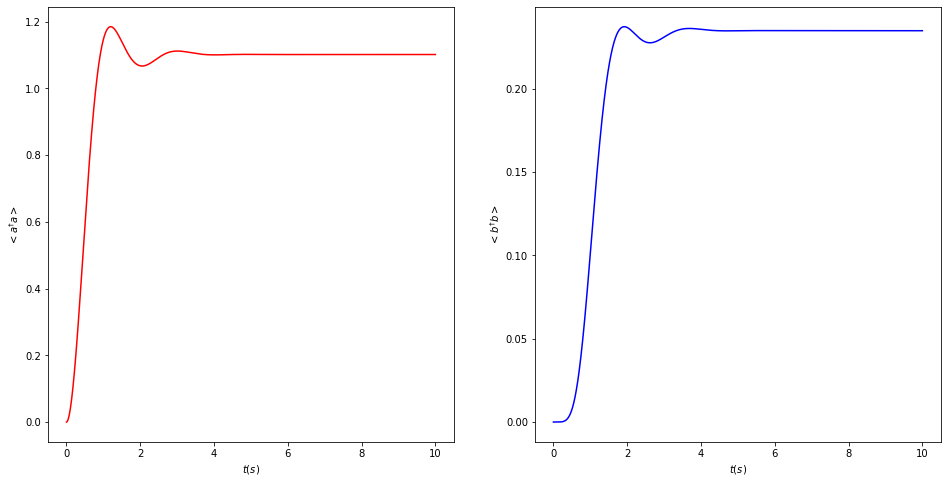

In [6]:
fig1, axes1 = plt.subplots(1, 2, figsize=(16,8))
axes1[0].set_xlabel(r'$t(s)$');axes1[1].set_xlabel(r'$t(s)$')
axes1[0].set_ylabel(r'$<a^{\dagger}a>$')
axes1[1].set_ylabel(r'$<b^{\dagger}b>$')
axes1[0].plot(tlist,sol[...,3],color='red',linestyle='-',label='Manual-a')
axes1[1].plot(tlist,sol[...,5],color='blue',linestyle='-',label='Manual-b')

## Build up the automatic version

In [7]:
Hamilton=[['Aa',ps.Delta[0]],['Bb',ps.Delta[1]],['AAb',ps.g],['aaB',ps.g],['A',ps.E],['a',ps.E]];print(Hamilton)
Co_ps=[['a',2],['b',4]];print(Co_ps)
T_o=['Aa','Bb'];print(T_o)

[['Aa', 0.8], ['Bb', 1.6], ['AAb', 1], ['aaB', 1], ['A', 2], ['a', 2]]
[['a', 2], ['b', 4]]
['Aa', 'Bb']


In [21]:
d=QCLData.Data(Hamilton, Co_ps, T_o, 5)
tic=time.time()
sol2=QCLS.Solve(d, [0,0], (0,10), t_eval=tlist)
toc=time.time()
t_cluster=toc-tic

In [9]:
print(sol2.y[0,-1],sol2.y[1,-1])

(1.2940019132613287+0j) (0.21057151842951102+0j)


## Build up the qutip version

In [11]:
tic=time.time()
output=ps.AdvanceCalculator(1e-8,1e-6,tlist)
toc=time.time()
t_qutip=toc-tic
n_a = output.expect[0];n_b = output.expect[1]

a square error:1.231353684841415e-07
b square error:6.258099751557762e-08


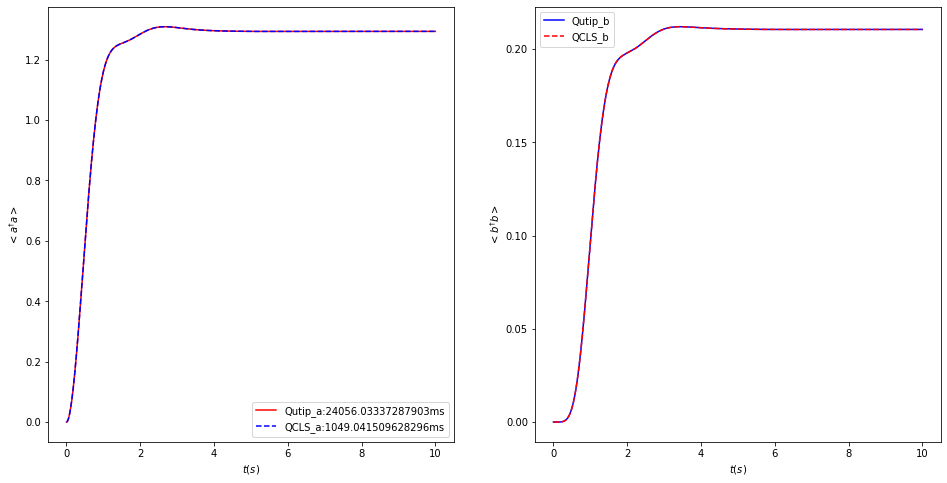

In [22]:
fig3, axes3 = plt.subplots(1, 2, figsize=(16,8))
axes3[0].set_xlabel(r'$t(s)$');axes3[1].set_xlabel(r'$t(s)$')
axes3[0].set_ylabel(r'$<a^{\dagger}a>$')
axes3[1].set_ylabel(r'$<b^{\dagger}b>$')
axes3[0].plot(tlist,n_a,color='red',linestyle='-',label='Qutip_a:'+str(1000*t_qutip)+'ms')
axes3[1].plot(tlist,n_b,color='blue',linestyle='-',label='Qutip_b')
axes3[0].plot(sol2.t,np.real(sol2.y[0]),color='blue',linestyle='--',label='QCLS_a:'+str(1000*t_cluster)+'ms')
axes3[1].plot(sol2.t,np.real(sol2.y[1]),color='red',linestyle='--',label='QCLS_b')
axes3[0].legend(loc=0)
axes3[1].legend(loc=0)
cost_a=np.sqrt(np.sum(np.power(sol2.y[0]-n_a,2)))/len(tlist)
cost_b=np.sqrt(np.sum(np.power(sol2.y[1]-n_b,2)))/len(tlist)
print('a square error:'+str(np.real(cost_a)))
print('b square error:'+str(np.real(cost_b)))

In [13]:
print(n_a[-1],n_b[-1])

1.2938565451268562 0.21060862809018902


In [14]:
cost_a=np.sqrt(np.sum(np.power(sol2.y[0]-n_a,2)))/len(tlist)
cost_b=np.sqrt(np.sum(np.power(sol2.y[1]-n_b,2)))/len(tlist)
print(np.real(cost_a),np.real(cost_b))

3.924405524553642e-07 1.0215277714147148e-07
